# 개요
- 출처
  - 원본 데이터 셋
    - [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 개요 
  - 세계보건기구(WHO)에 따르면 뇌졸중은 전체 사망자의 약 11%를 차지하는 세계 2위의 사망 원인이다. 
  - 이 데이터 세트는 성별, 나이, 다양한 질병 및 흡연 상태와 같은 입력 매개 변수를 기반으로 환자가 뇌졸중에 걸릴 가능성이 있는지 예측 
  - 각 행은 환자에 대한 관련 정보를 제공한다.
- 평가지표 : ROC Curve
- 타임라인 : 2023.1.10 ~ 2023.1.16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv')

In [ ]:
# train, test, submission 인덱스 확인
train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

```
< 각 열에 대한 정보 확인 >
'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스와 같은 의미
'gender', : Male, Female, other로 구성됨 -> 범주형
'age', : 나이 /  수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 이진형
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 이진형
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 범주형(이진)
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 범주형(명목형)
'Residence_type', : 거주지 유형 /  Urban, Rural / 도시, 시골 => 범주형(이진)
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 범주형(명목형)
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답(target)
```






In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes
...,...,...,...,...,...,...,...,...,...,...
25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked
25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown
25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  object 
 5   work_type          10204 non-null  object 
 6   Residence_type     10204 non-null  object 
 7   avg_glucose_level  10204 non-null  float64
 8   bmi                10204 non-null  float64
 9   smoking_status     10204 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 876.9+ KB


In [ ]:
original

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [ ]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [ ]:
submission

,stroke
id,
15304,0.041296
15305,0.041296
15306,0.041296
15307,0.041296
15308,0.041296
...,...
25503,0.041296
25504,0.041296
25505,0.041296


# 초기 파악



## 결측치 확인

In [ ]:
# original 결측값 확인됨
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(original)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# null값 비율 확인 시 original 데이터에 결측치가 존재

bmi                  3.933464
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
dtype: float64


<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [ ]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= original.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 분포 확인 시 별 차이가 안 보인다

hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   104
bmi                   418
avg_glucose_level    3979
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   407
avg_glucose_level    3740
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   400
avg_glucose_level    3265
dtype: int64


<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [ ]:
train.shape, train.drop_duplicates().shape

((15304, 11), (15304, 11))

In [ ]:
test.shape, test.drop_duplicates().shape

((10204, 10), (10204, 10))

In [ ]:
original.shape, original.drop_duplicates().shape

((5110, 11), (5110, 11))

## 전체 요약

In [ ]:
def summary(df, train=train):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.loc[0].values
    sum_df['second value'] = df.loc[1].values
    sum_df['third value'] = df.loc[2].values
    
    return sum_df
summary_df = summary(train)
summary_df

data shape: (15304, 11)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Male,Male,Female
age,float64,0,106,0.08,82.0,41.417708,28.0,33.0,42.0
hypertension,int64,0,2,0.0,1.0,0.049726,0,0,0
heart_disease,int64,0,2,0.0,1.0,0.023327,0,0,0
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,Yes
work_type,object,0,5,NaN,NaN,NaN,Private,Private,Private
Residence_type,object,0,2,NaN,NaN,NaN,Urban,Rural,Rural
avg_glucose_level,float64,0,3740,55.22,267.6,89.039853,79.53,78.44,103.0
bmi,float64,0,407,10.3,80.1,28.112721,31.1,23.9,40.3
smoking_status,object,0,4,NaN,NaN,NaN,never smoked,formerly smoked,Unknown


In [ ]:
summary_df2 = summary(origin)
summary_df2

In [ ]:
summary_df3 = summary(test)
summary_df3

# EDA

## Target 분포 확인

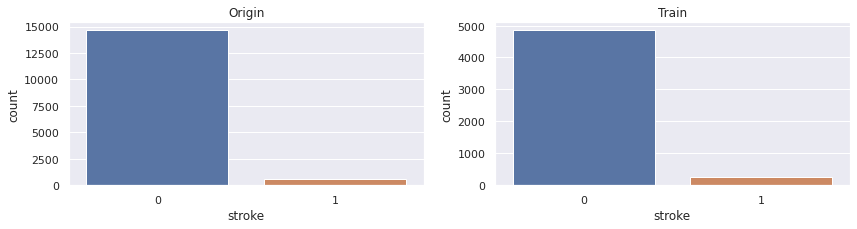

In [ ]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.countplot(data=train, x='stroke');
plt.title('Origin')
ax2 = plt.subplot(1,2,2)
sns.countplot(data=origin, x='stroke');
plt.title('Train')
plt.show()
# 뇌졸중을 가진 사람보다 뇌졸중이 아닌 사람이 훨씬 많음 -> 데이터 불균형함 -> train/test 시 startify = y 설정 또는 startify-fold로 모델 평가 진행

## 피처 요약 기준 해석 및 전략 수립

- 수치형
  - age
  - avg_glucose_level
  - bmi


In [ ]:
# 수치형, 범주형, 명목형 분류

# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 

# 범주형
cat_cols = ['gender', 'hypertension','heart_disease','ever_married','work_type', 'Residence_type', 'smoking_status'] 

# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married']
cat_cols_v2 = ['work_type', 'smoking_status']

In [ ]:
# 범주형 변수의 고유값 수
print(pd.unique(train["gender"]))
print(pd.unique(train["smoking_status"]))
print(pd.unique(train["ever_married"]))
print(pd.unique(train["work_type"]))
print(pd.unique(train["Residence_type"]))

### Displot

In [ ]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

### Boxplot

In [ ]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 나이는 일반적으로 20세에서 60세 사이의 연령 분포에 속함
# BMI, 당 수치는 정상인 것 같지만 수치가 높음
# avg_lucose_level이 정상인 것처럼 보이기 때문에, 우리가 볼 수 있듯이 더 높은 값이 있다
# Bmi에는 40이상의 높은 수치가 있는데, 이는 40이상의 수치를 가진 사람들이 높은 비만 위험을 짊어질 수 있다는 것을 의미한다
# -> 그러므로, 이상치로 보기가 쉽지 않음

### Countplot

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

In [ ]:
for f in cat_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.countplot(x= origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.countplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.countplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show() 

# Gender는 여성이 좀 더 많음
# 고혈압, 심장병 여부는 뇌졸증(target)가 비율이 유사
# 거주지 타입의 비율을 거의 동일
# 작업 유형은 민간 직업이 많음

#### Gender

In [ ]:
# gender의 개수 시각화  -> 남성보다 여성 분포가 많이 보임
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = train)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

In [ ]:
# gender가 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'gender', hue='stroke', data = train )
ax.set_title('Gender vs Stroke counts')
plt.show()

In [ ]:
# gender 고유값별 개수 확인
train['gender'].value_counts()

In [ ]:
# 교차분석표 함수화 처리
def make_cross_tab(df, feature):
  cross_tab = pd.crosstab( df[feature], df['stroke'], normalize='index') *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

In [ ]:
make_cross_tab(train,'gender')
# 이를 통해서 여성보다는 남성이 뇌졸증이 걸리기 쉽다
# Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
# other은 1명 존재하며 뇌졸중 환자가 아님 -> 이상치로 확인 

#### hypertension

In [ ]:
# hypertension이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'hypertension', hue='stroke', data = train )
ax.set_title('hypertension vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'hypertension')
# 고혈압을 앓고 있는 사람들은 고혈압이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

#### heart_disease

In [ ]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'heart_disease', hue='stroke', data = train )
ax.set_title('heart_disease vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'heart_disease')
# 심장병을 앓고 있는 사람들은 심장병이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

#### ever_married

In [ ]:
# ever_married이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'ever_married', hue='stroke', data = train )
ax.set_title('ever_married vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'ever_married')
# 결혼하면 오히려 뇌졸증에 걸리기 쉬움..?

#### work_type

In [ ]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'work_type', hue='stroke', data = train )
ax.set_title('work_type vs Stroke counts')
plt.show()

In [ ]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

In [ ]:
make_cross_tab(train,'work_type')
# 일을 해본 사람들은 뇌졸중 위험 확률이 가장 높다 / 일을 아예 한 사람은 가장 낮음
# -> 다만 데이터 분포가 적은 Never_worked, children과  Govt_job	, Private을 합쳐서 새로운 피처를 만들수 있겠다	

#### Residence_type

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'Residence_type', hue='stroke', data = train )
ax.set_title('Residence_type vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'Residence_type')
# -> 대상 변수에 대한 값의 영향이 동일하기 때문에 이 기능인 Residence_type을 제거하는 것을 고려

#### smoking_status

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'smoking_status', hue='stroke', data = train )
ax.set_title('smoking_status vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'smoking_status')
# 알려지지 않은 값과 절대 흡연하지 않는 값은 뇌졸중에 걸릴 가능성이 낮은 반면 
# 이전에 흡연된 값과 흡연 값은 뇌졸중에 걸릴 가능성이 더 높습니다.

### Stripplot

- age :  뇌졸중에 걸린 사람들은 일반적으로 40-80 사이에 분포되어 있고, 여성이 남성보다 더 많다, 젊은 사람들은 거의 X 
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨

In [ ]:
# 범주형 데이터의 산점도 : stripplot : (https://steadiness-193.tistory.com/184) 

strip_feat = ['age','bmi','avg_glucose_level']

for f in strip_feat:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,2,1)
  sns.stripplot( x="stroke", y = f, hue="gender", data=origin)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,2,2)
  sns.stripplot( x="stroke", y = f,hue="gender", data=train)
  plt.title(f + ' - Train')
  plt.grid()
  plt.show() 

### Lineplot

- 첫 번째 그래프의 경우, 20-60세 사이의 사람들은 높은 bmi 값을 가진다
- 두 번째 그래프에 따르면, 40세 이상의 사람들은 당 수치가 높다는 것을 의미하는데, 이는 이 사람들이 당뇨병 환자가 될 수 있다.
- 마지막 그래프의 경우, 당 수치가 낮으면 bmi도 같이 낮아진다(상관관계).

In [ ]:
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=2)

sns.set_style('whitegrid')

ax1 = sns.lineplot(x="age",y="bmi",data=origin, ax=axes[0][0])
ax1.set_title("Age and Bmi Relationship")

ax2 = sns.lineplot(x="age",y="avg_glucose_level",data=origin, ax=axes[0][1])
ax2.set_title("Age and Average Glucose Level Relationship")

ax3 = sns.lineplot(x="avg_glucose_level",y="bmi",data=origin, ax=axes[0][2])
ax3.set_title("Average Glucose Level and Bmi Relationship")

ax4 = sns.lineplot(x="age",y="bmi",data=train, ax=axes[1][0])
ax4.set_title("Age and Bmi Relationship")

ax5 = sns.lineplot(x="age",y="avg_glucose_level",data=train, ax=axes[1][1])
ax5.set_title("Age and Average Glucose Level Relationship")

ax6 = sns.lineplot(x="avg_glucose_level",y="bmi",data=train, ax=axes[1][2])
ax6.set_title("Average Glucose Level and Bmi Relationship")

plt.show()

## Heatmap

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(origin.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("origin person corr")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# Age, hypertension,avg_glucose_level,heart_disease, bmi대체적으로 상관관계가 있음

# 피처 엔지니어링

In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv')

origin.shape, train.shape, test.shape, submission.shape

((5110, 12), (15304, 12), (10204, 11), (10204, 2))

In [ ]:
# origin 데이터에서 뇌졸증 환자만 가져옴
original_st =  origin[origin[['stroke']].all(1)]
# train 데이터 셋에 추가
train = pd.concat((train, original_st))
train.shape

(15553, 12)

## 데이터 합치기

In [ ]:
all_data = pd.concat([train,test], ignore_index=True)
all_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0.0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0.0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0.0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0.0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25752,25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked,NaN
25753,25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown,NaN
25754,25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown,NaN
25755,25506,Male,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked,NaN


In [ ]:
# 'Residence_type', 'bmi' 삭제 => 변별력 무 
# original - bmi 결측치 있었으나 사용하지 않을 항목으로 결측치 보완하지 않고 삭제함
all_data.drop(columns=['id','bmi','Residence_type'],inplace=True)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             25757 non-null  object 
 1   age                25757 non-null  float64
 2   hypertension       25757 non-null  int64  
 3   heart_disease      25757 non-null  int64  
 4   ever_married       25757 non-null  object 
 5   work_type          25757 non-null  object 
 6   avg_glucose_level  25757 non-null  float64
 7   smoking_status     25757 non-null  object 
 8   stroke             15553 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.8+ MB


## 인코딩

### 범주형 데이터 인코딩

- gender 
  - gender의 other를 male로 변환
- smoking_status
  - 비흡연 vs 흡연 => 이진형 형태로 진행
  - smoking_status의 Unknown을 never_smoked로 변환
  - smoking_status의 formerly smoked를 smoked로 변환


In [ ]:
# gender의 other 위치 확인
all_data[all_data['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
9363,Other,9.0,0,0,No,children,96.04,Unknown,0.0
20182,Other,56.0,0,0,Yes,Private,102.53,Unknown,NaN


In [ ]:
# Other 값을 Male로 변경
all_data["gender"] = all_data["gender"].replace({
    'Other': 'Male',
})

In [ ]:
print(pd.unique(all_data["gender"]))

['Male' 'Female']


In [ ]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'gender')

In [ ]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = all_data)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

- smoking_status
  - 비흡연 vs 흡연 => 이진형 형태로 변환
  - smoking_status의 Unknown을 never_smoked로 변환
  - smoking_status의 formerly smoked를 smoked로 변환

In [ ]:
# smoking_status에 unknown 확인
print(pd.unique(all_data["smoking_status"]))

['never smoked' 'formerly smoked' 'Unknown' 'smokes']


In [ ]:
# Unknown -> never smoked / 'formerly smoked' -> 'smokes' 변경
all_data["smoking_status"] = all_data["smoking_status"].replace({
    'Unknown': 'never smoked',
    'formerly smoked': 'smokes'
})

In [ ]:
print(pd.unique(all_data["smoking_status"]))

['never smoked' 'smokes']


In [ ]:
all_data['smoking_status'].value_counts()

In [ ]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'smoking_status')

In [ ]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'smoking_status', data = all_data)
ax.set_title('Smoking_status Count', fontdict={'fontsize': 16})
plt.show()

- Work_type
  - work_type 중 children 을 Never_worked로 대체해보기 
  - private와 Govt_job 합쳐보기 

In [ ]:
# work_type 중 children 을 Never_worked로 대체해보기 
# private와 Govt_job 합쳐보기 
all_data['work_type'] = all_data['work_type'].replace({
    'children' : 'Never_worked',
    'Private' : 'employee',
    'Govt_job' :'employee'})

In [ ]:
all_data['work_type'].unique() 

array(['employee', 'Self-employed', 'Never_worked'], dtype=object)

In [ ]:
# 교차분석표 확인
make_cross_tab(all_data,'work_type')

In [ ]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'work_type', data = all_data)
ax.set_title('Work_type', fontdict={'fontsize': 16})
plt.show()

### 명목형 데이터 중 문자열로 되어 있는 데이터 수치형으로 변환

In [ ]:
# 문자형 데이터를 수치형으로 변경
# all_data 파일
# gender
all_data['gender'] = all_data['gender'].map({
    'Male': 0,
    'Female': 1,
}).astype('int')

# ever_married
all_data['ever_married'] = all_data['ever_married'].map({
    'Yes': 1,
    'No': 0
}).astype('int')

# work_type
all_data['work_type'] = all_data['work_type'].map({
    'employee':0,
    'Self-employed': 1,
    'Never_worked': 2
}).astype('int')

# smoking_status
all_data['smoking_status'] = all_data['smoking_status'].map({
    'never smoked' : 0,
    'smokes': 1
}).astype('int')

In [ ]:
# age와 avg_glucose_level이 float형태이므로 int 형태로 변환 필요 

all_data['age'] = all_data['age'].astype(int)
all_data['avg_glucose_level'] = all_data['avg_glucose_level'].astype(int)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             25757 non-null  int64  
 1   age                25757 non-null  int64  
 2   hypertension       25757 non-null  int64  
 3   heart_disease      25757 non-null  int64  
 4   ever_married       25757 non-null  int64  
 5   work_type          25757 non-null  int64  
 6   avg_glucose_level  25757 non-null  int64  
 7   smoking_status     25757 non-null  int64  
 8   stroke             15553 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 1.8 MB


# 피처 스케일링

In [ ]:
num_features = ['age', 'avg_glucose_level']

minmax = MinMaxScaler()

all_data[num_features]= minmax.fit_transform(all_data[num_features])

## 데이터 나누기

In [ ]:
# 정답의 결측 여부로 해결
X_sub = all_data[pd.isnull(all_data['stroke'])] # submisson용

# 훈련용
X = all_data[~pd.isnull(all_data['stroke'])] 
print(X.shape, X_sub.shape)
X.head() # Price 제거 필요

(15553, 9) (10204, 9)


,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
0,0,0.341463,0,0,1,0,0.111111,0,0.0
1,0,0.402439,0,0,1,0,0.106481,1,0.0
2,1,0.512195,0,0,1,0,0.222222,0,0.0
3,0,0.682927,0,0,1,0,0.041667,0,0.0
4,1,0.292683,0,0,0,0,0.083333,0,0.0


In [ ]:
y = X['stroke']
X = X.drop( ['stroke'], axis=1 )
X_sub = X_sub.drop( ['stroke'], axis=1 )

In [ ]:
print(X.shape, X_sub.shape, y.shape)

(15553, 8) (10204, 8) (15553,)


In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11664, 8) (3889, 8) (11664,) (3889,)


# 베이스 모델 구축

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 이진 분류, 선형 모델을 내부적으로 가지고, 피처가 많아도 학습 속도가 빠른 로지스틱 회귀 사용
clf = LogisticRegression()

# 하이퍼파라미터 값 목록
clf_params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], # 규제 강도, 높을 수록 강함
             'max_iter':[10, 50, 100, 200, 400, 600, 800, 1000], #  모델 성능을 오리기 위해서 학습의 반복 횟수 제한
             'solver':['liblinear'], # 과적합 방지 지표 :  L1,L2를 모두 지원
             'random_state':[0]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(clf,clf_params,scoring='roc_auc',cv=10)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 16 s, sys: 12.2 s, total: 28.2 s
Wall time: 17 s


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [10, 50, 100, 200, 400, 600, 800, 1000],
                         'random_state': [0], 'solver': ['liblinear']},
             scoring='roc_auc')

In [ ]:
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)
print('위 하이퍼파리머터 사용시 roc_auc ', gridsearch_logistic_model.best_score_)

최적 하이퍼파라미터: {'C': 10, 'max_iter': 10, 'random_state': 0, 'solver': 'liblinear'}
위 하이퍼파리머터 사용시 roc_auc  0.8868777621358681


In [ ]:
y_preds = gridsearch_logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_test, y_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8927


In [ ]:
# 풀 데이터 활용 
gridsearch_logistic_model.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [10, 50, 100, 200, 400, 600, 800, 1000],
                         'random_state': [0], 'solver': ['liblinear']},
             scoring='roc_auc')

In [ ]:
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)
print('위 하이퍼파리머터 사용시 roc_auc ', gridsearch_logistic_model.best_score_)

최적 하이퍼파라미터: {'C': 1, 'max_iter': 10, 'random_state': 0, 'solver': 'liblinear'}
위 하이퍼파리머터 사용시 roc_auc  0.888185677229567


In [ ]:
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_sub)[:,1]
y_preds

array([0.04628185, 0.19754523, 0.000829  , ..., 0.00071492, 0.00667994,
       0.00053304])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(y_preds.reshape(-1, 1))

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.058849
1,15305,0.252543
2,15306,0.000646
3,15307,0.053960
4,15308,0.014229


In [ ]:
submission.to_csv('submission_basic.csv', index=False )
# Private Score: 0.88878 / Public score: 0.86597

# 모델 비교

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def roc_auc_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    roc_auc_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, pred)
        roc_auc_list.append(roc_auc)
    return model_name, roc_auc_list

def print_roc_auc_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = roc_auc_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} ROC AUC: {r:.4f}')
    print(f'\n{model_name} mean ROC AUC: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier()

In [ ]:
models = []
scores = []
for model in [lr, dt, rf, gb, ada, xgb, lgbm, cat]:
    model_name, mean_score = print_roc_auc_score(model)
    models.append(model_name)
    scores.append(mean_score)

LogisticRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 40.55it/s]


1 FOLDS: LogisticRegression ROC AUC: 0.8806
2 FOLDS: LogisticRegression ROC AUC: 0.8648
3 FOLDS: LogisticRegression ROC AUC: 0.8857
4 FOLDS: LogisticRegression ROC AUC: 0.8793
5 FOLDS: LogisticRegression ROC AUC: 0.8874
6 FOLDS: LogisticRegression ROC AUC: 0.8991
7 FOLDS: LogisticRegression ROC AUC: 0.8680
8 FOLDS: LogisticRegression ROC AUC: 0.8679
9 FOLDS: LogisticRegression ROC AUC: 0.8947
10 FOLDS: LogisticRegression ROC AUC: 0.8915

LogisticRegression mean ROC AUC: 0.8819


DecisionTreeClassifier Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 61.44it/s]


1 FOLDS: DecisionTreeClassifier ROC AUC: 0.6246
2 FOLDS: DecisionTreeClassifier ROC AUC: 0.5950
3 FOLDS: DecisionTreeClassifier ROC AUC: 0.6045
4 FOLDS: DecisionTreeClassifier ROC AUC: 0.6450
5 FOLDS: DecisionTreeClassifier ROC AUC: 0.6603
6 FOLDS: DecisionTreeClassifier ROC AUC: 0.6006
7 FOLDS: DecisionTreeClassifier ROC AUC: 0.6284
8 FOLDS: DecisionTreeClassifier ROC AUC: 0.6468
9 FOLDS: DecisionTreeClassifier ROC AUC: 0.6290
10 FOLDS: DecisionTreeClassifier ROC AUC: 0.6074

DecisionTreeClassifier mean ROC AUC: 0.6242


RandomForestClassifier Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


1 FOLDS: RandomForestClassifier ROC AUC: 0.8257
2 FOLDS: RandomForestClassifier ROC AUC: 0.8041
3 FOLDS: RandomForestClassifier ROC AUC: 0.8454
4 FOLDS: RandomForestClassifier ROC AUC: 0.8197
5 FOLDS: RandomForestClassifier ROC AUC: 0.8542
6 FOLDS: RandomForestClassifier ROC AUC: 0.8179
7 FOLDS: RandomForestClassifier ROC AUC: 0.8362
8 FOLDS: RandomForestClassifier ROC AUC: 0.8006
9 FOLDS: RandomForestClassifier ROC AUC: 0.8554
10 FOLDS: RandomForestClassifier ROC AUC: 0.8082

RandomForestClassifier mean ROC AUC: 0.8267


GradientBoostingClassifier Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


1 FOLDS: GradientBoostingClassifier ROC AUC: 0.8497
2 FOLDS: GradientBoostingClassifier ROC AUC: 0.8580
3 FOLDS: GradientBoostingClassifier ROC AUC: 0.8926
4 FOLDS: GradientBoostingClassifier ROC AUC: 0.8821
5 FOLDS: GradientBoostingClassifier ROC AUC: 0.8915
6 FOLDS: GradientBoostingClassifier ROC AUC: 0.9078
7 FOLDS: GradientBoostingClassifier ROC AUC: 0.8726
8 FOLDS: GradientBoostingClassifier ROC AUC: 0.8772
9 FOLDS: GradientBoostingClassifier ROC AUC: 0.9019
10 FOLDS: GradientBoostingClassifier ROC AUC: 0.8833

GradientBoostingClassifier mean ROC AUC: 0.8817


AdaBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


1 FOLDS: AdaBoostClassifier ROC AUC: 0.8884
2 FOLDS: AdaBoostClassifier ROC AUC: 0.8627
3 FOLDS: AdaBoostClassifier ROC AUC: 0.8899
4 FOLDS: AdaBoostClassifier ROC AUC: 0.8986
5 FOLDS: AdaBoostClassifier ROC AUC: 0.8982
6 FOLDS: AdaBoostClassifier ROC AUC: 0.9084
7 FOLDS: AdaBoostClassifier ROC AUC: 0.8659
8 FOLDS: AdaBoostClassifier ROC AUC: 0.8688
9 FOLDS: AdaBoostClassifier ROC AUC: 0.9009
10 FOLDS: AdaBoostClassifier ROC AUC: 0.8737

AdaBoostClassifier mean ROC AUC: 0.8855


XGBClassifier Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


1 FOLDS: XGBClassifier ROC AUC: 0.8818
2 FOLDS: XGBClassifier ROC AUC: 0.8639
3 FOLDS: XGBClassifier ROC AUC: 0.8944
4 FOLDS: XGBClassifier ROC AUC: 0.8826
5 FOLDS: XGBClassifier ROC AUC: 0.8909
6 FOLDS: XGBClassifier ROC AUC: 0.9058
7 FOLDS: XGBClassifier ROC AUC: 0.8706
8 FOLDS: XGBClassifier ROC AUC: 0.8694
9 FOLDS: XGBClassifier ROC AUC: 0.9030
10 FOLDS: XGBClassifier ROC AUC: 0.8816

XGBClassifier mean ROC AUC: 0.8844


LGBMClassifier Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  9.92it/s]


1 FOLDS: LGBMClassifier ROC AUC: 0.8643
2 FOLDS: LGBMClassifier ROC AUC: 0.8456
3 FOLDS: LGBMClassifier ROC AUC: 0.8740
4 FOLDS: LGBMClassifier ROC AUC: 0.8589
5 FOLDS: LGBMClassifier ROC AUC: 0.8753
6 FOLDS: LGBMClassifier ROC AUC: 0.8823
7 FOLDS: LGBMClassifier ROC AUC: 0.8583
8 FOLDS: LGBMClassifier ROC AUC: 0.8640
9 FOLDS: LGBMClassifier ROC AUC: 0.8969
10 FOLDS: LGBMClassifier ROC AUC: 0.8782

LGBMClassifier mean ROC AUC: 0.8698


CatBoostClassifier Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.010579
0:	learn: 0.6729626	total: 47.4ms	remaining: 47.3s
1:	learn: 0.6542947	total: 47.9ms	remaining: 23.9s
2:	learn: 0.6397371	total: 49.2ms	remaining: 16.4s
3:	learn: 0.6261396	total: 50.1ms	remaining: 12.5s
4:	learn: 0.6089745	total: 50.9ms	remaining: 10.1s
5:	learn: 0.5899799	total: 51.8ms	remaining: 8.58s
6:	learn: 0.5764645	total: 52.6ms	remaining: 7.47s
7:	learn: 0.5628334	total: 53.5ms	remaining: 6.63s
8:	learn: 0.5494372	total: 54.3ms	remaining: 5.98s
9:	learn: 0.5394722	total: 55ms	remaining: 5.45s
10:	learn: 0.5285520	total: 55.7ms	remaining: 5.01s
11:	learn: 0.5129922	total: 56.5ms	remaining: 4.65s
12:	learn: 0.4991558	total: 57.4ms	remaining: 4.36s
13:	learn: 0.4869852	total: 58.3ms	remaining: 4.11s
14:	learn: 0.4783840	total: 59.1ms	remaining: 3.88s
15:	learn: 0.4667773	total: 59.9ms	remaining: 3.69s
16:	learn: 0.4562424	total: 60.8ms	remaining: 3.51s
17:	learn: 0.4453875	total: 61.6ms	remaining: 3.36s
18:	learn: 0.4342544	total: 62.5ms	remaining: 

CatBoostClassifier Cross Validations...:  10%|█         | 1/10 [00:01<00:10,  1.21s/it]

883:	learn: 0.0617122	total: 902ms	remaining: 118ms
884:	learn: 0.0616515	total: 903ms	remaining: 117ms
885:	learn: 0.0616074	total: 904ms	remaining: 116ms
886:	learn: 0.0615786	total: 905ms	remaining: 115ms
887:	learn: 0.0615503	total: 906ms	remaining: 114ms
888:	learn: 0.0614446	total: 907ms	remaining: 113ms
889:	learn: 0.0614289	total: 908ms	remaining: 112ms
890:	learn: 0.0614119	total: 909ms	remaining: 111ms
891:	learn: 0.0613683	total: 910ms	remaining: 110ms
892:	learn: 0.0613512	total: 910ms	remaining: 109ms
893:	learn: 0.0613227	total: 911ms	remaining: 108ms
894:	learn: 0.0612839	total: 912ms	remaining: 107ms
895:	learn: 0.0612588	total: 913ms	remaining: 106ms
896:	learn: 0.0612449	total: 914ms	remaining: 105ms
897:	learn: 0.0612171	total: 915ms	remaining: 104ms
898:	learn: 0.0611959	total: 916ms	remaining: 103ms
899:	learn: 0.0611624	total: 917ms	remaining: 102ms
900:	learn: 0.0610868	total: 918ms	remaining: 101ms
901:	learn: 0.0609921	total: 918ms	remaining: 99.8ms
902:	learn:

CatBoostClassifier Cross Validations...:  20%|██        | 2/10 [00:02<00:10,  1.35s/it]

906:	learn: 0.0745835	total: 1.15s	remaining: 117ms
907:	learn: 0.0745674	total: 1.15s	remaining: 117ms
908:	learn: 0.0745331	total: 1.15s	remaining: 115ms
909:	learn: 0.0744767	total: 1.15s	remaining: 114ms
910:	learn: 0.0744213	total: 1.15s	remaining: 113ms
911:	learn: 0.0744021	total: 1.16s	remaining: 111ms
912:	learn: 0.0743327	total: 1.16s	remaining: 110ms
913:	learn: 0.0742586	total: 1.16s	remaining: 109ms
914:	learn: 0.0742261	total: 1.16s	remaining: 108ms
915:	learn: 0.0741817	total: 1.16s	remaining: 106ms
916:	learn: 0.0740704	total: 1.16s	remaining: 105ms
917:	learn: 0.0739614	total: 1.16s	remaining: 104ms
918:	learn: 0.0739102	total: 1.16s	remaining: 103ms
919:	learn: 0.0738537	total: 1.16s	remaining: 101ms
920:	learn: 0.0738382	total: 1.17s	remaining: 99.9ms
921:	learn: 0.0737977	total: 1.17s	remaining: 98.7ms
922:	learn: 0.0737650	total: 1.17s	remaining: 97.4ms
923:	learn: 0.0737299	total: 1.17s	remaining: 96.1ms
924:	learn: 0.0736768	total: 1.17s	remaining: 94.8ms
925:	le

CatBoostClassifier Cross Validations...:  30%|███       | 3/10 [00:05<00:13,  1.92s/it]

985:	learn: 0.0918707	total: 2.12s	remaining: 30.1ms
986:	learn: 0.0918378	total: 2.13s	remaining: 28ms
987:	learn: 0.0917604	total: 2.13s	remaining: 25.8ms
988:	learn: 0.0917280	total: 2.13s	remaining: 23.7ms
989:	learn: 0.0916816	total: 2.13s	remaining: 21.5ms
990:	learn: 0.0916406	total: 2.13s	remaining: 19.4ms
991:	learn: 0.0916126	total: 2.13s	remaining: 17.2ms
992:	learn: 0.0915566	total: 2.13s	remaining: 15.1ms
993:	learn: 0.0915374	total: 2.14s	remaining: 12.9ms
994:	learn: 0.0915347	total: 2.14s	remaining: 10.8ms
995:	learn: 0.0914892	total: 2.15s	remaining: 8.62ms
996:	learn: 0.0914349	total: 2.15s	remaining: 6.47ms
997:	learn: 0.0913824	total: 2.15s	remaining: 4.32ms
998:	learn: 0.0913538	total: 2.16s	remaining: 2.16ms
999:	learn: 0.0912877	total: 2.16s	remaining: 0us
Learning rate set to 0.019098
0:	learn: 0.6538355	total: 1.95ms	remaining: 1.95s
1:	learn: 0.6244281	total: 6.11ms	remaining: 3.05s
2:	learn: 0.5971147	total: 9.31ms	remaining: 3.09s
3:	learn: 0.5756711	total: 

CatBoostClassifier Cross Validations...:  40%|████      | 4/10 [00:07<00:13,  2.17s/it]

939:	learn: 0.0982823	total: 2.13s	remaining: 136ms
940:	learn: 0.0982074	total: 2.13s	remaining: 134ms
941:	learn: 0.0981905	total: 2.14s	remaining: 132ms
942:	learn: 0.0981876	total: 2.14s	remaining: 129ms
943:	learn: 0.0981234	total: 2.14s	remaining: 127ms
944:	learn: 0.0980775	total: 2.14s	remaining: 125ms
945:	learn: 0.0980245	total: 2.15s	remaining: 122ms
946:	learn: 0.0979792	total: 2.15s	remaining: 120ms
947:	learn: 0.0979642	total: 2.15s	remaining: 118ms
948:	learn: 0.0979197	total: 2.15s	remaining: 116ms
949:	learn: 0.0978720	total: 2.15s	remaining: 113ms
950:	learn: 0.0978496	total: 2.15s	remaining: 111ms
951:	learn: 0.0978146	total: 2.15s	remaining: 109ms
952:	learn: 0.0977291	total: 2.16s	remaining: 106ms
953:	learn: 0.0976830	total: 2.16s	remaining: 104ms
954:	learn: 0.0976555	total: 2.16s	remaining: 102ms
955:	learn: 0.0976470	total: 2.16s	remaining: 99.5ms
956:	learn: 0.0976016	total: 2.16s	remaining: 97.2ms
957:	learn: 0.0975595	total: 2.16s	remaining: 94.9ms
958:	lear

CatBoostClassifier Cross Validations...:  50%|█████     | 5/10 [00:09<00:10,  2.17s/it]

Learning rate set to 0.022705
0:	learn: 0.6461449	total: 1.85ms	remaining: 1.85s
1:	learn: 0.6115554	total: 3.46ms	remaining: 1.73s
2:	learn: 0.5795135	total: 5.71ms	remaining: 1.9s
3:	learn: 0.5503846	total: 7.65ms	remaining: 1.9s
4:	learn: 0.5191469	total: 10.8ms	remaining: 2.15s
5:	learn: 0.4914607	total: 12.9ms	remaining: 2.13s
6:	learn: 0.4665053	total: 14.8ms	remaining: 2.1s
7:	learn: 0.4445342	total: 16.7ms	remaining: 2.07s
8:	learn: 0.4234293	total: 18.7ms	remaining: 2.05s
9:	learn: 0.4048089	total: 20.6ms	remaining: 2.04s
10:	learn: 0.3902377	total: 22.5ms	remaining: 2.02s
11:	learn: 0.3739462	total: 24.4ms	remaining: 2s
12:	learn: 0.3601660	total: 26.2ms	remaining: 1.99s
13:	learn: 0.3472129	total: 28ms	remaining: 1.97s
14:	learn: 0.3337679	total: 29.9ms	remaining: 1.96s
15:	learn: 0.3227383	total: 31.8ms	remaining: 1.95s
16:	learn: 0.3101988	total: 33.7ms	remaining: 1.95s
17:	learn: 0.2984725	total: 35.5ms	remaining: 1.94s
18:	learn: 0.2909838	total: 37.1ms	remaining: 1.92s


CatBoostClassifier Cross Validations...:  60%|██████    | 6/10 [00:12<00:08,  2.24s/it]

977:	learn: 0.1027093	total: 2.11s	remaining: 47.5ms
978:	learn: 0.1026943	total: 2.11s	remaining: 45.3ms
979:	learn: 0.1026686	total: 2.11s	remaining: 43.2ms
980:	learn: 0.1026490	total: 2.12s	remaining: 41.1ms
981:	learn: 0.1026355	total: 2.13s	remaining: 39ms
982:	learn: 0.1025905	total: 2.13s	remaining: 36.8ms
983:	learn: 0.1025644	total: 2.13s	remaining: 34.6ms
984:	learn: 0.1025213	total: 2.13s	remaining: 32.5ms
985:	learn: 0.1024917	total: 2.13s	remaining: 30.3ms
986:	learn: 0.1024508	total: 2.13s	remaining: 28.1ms
987:	learn: 0.1024095	total: 2.14s	remaining: 26ms
988:	learn: 0.1023702	total: 2.14s	remaining: 23.8ms
989:	learn: 0.1023433	total: 2.14s	remaining: 21.6ms
990:	learn: 0.1023037	total: 2.14s	remaining: 19.5ms
991:	learn: 0.1022568	total: 2.14s	remaining: 17.3ms
992:	learn: 0.1022142	total: 2.15s	remaining: 15.1ms
993:	learn: 0.1021892	total: 2.15s	remaining: 13ms
994:	learn: 0.1021513	total: 2.15s	remaining: 10.8ms
995:	learn: 0.1021119	total: 2.15s	remaining: 8.64ms

CatBoostClassifier Cross Validations...:  70%|███████   | 7/10 [00:14<00:07,  2.35s/it]

945:	learn: 0.1012500	total: 2.24s	remaining: 128ms
946:	learn: 0.1012115	total: 2.25s	remaining: 126ms
947:	learn: 0.1011760	total: 2.25s	remaining: 124ms
948:	learn: 0.1011577	total: 2.26s	remaining: 121ms
949:	learn: 0.1011404	total: 2.26s	remaining: 119ms
950:	learn: 0.1011039	total: 2.26s	remaining: 117ms
951:	learn: 0.1010934	total: 2.27s	remaining: 114ms
952:	learn: 0.1010841	total: 2.27s	remaining: 112ms
953:	learn: 0.1010327	total: 2.27s	remaining: 110ms
954:	learn: 0.1010008	total: 2.27s	remaining: 107ms
955:	learn: 0.1009566	total: 2.28s	remaining: 105ms
956:	learn: 0.1009436	total: 2.28s	remaining: 102ms
957:	learn: 0.1009268	total: 2.28s	remaining: 100ms
958:	learn: 0.1009026	total: 2.28s	remaining: 97.6ms
959:	learn: 0.1008937	total: 2.29s	remaining: 95.2ms
960:	learn: 0.1008752	total: 2.29s	remaining: 92.8ms
961:	learn: 0.1008554	total: 2.29s	remaining: 90.4ms
962:	learn: 0.1008242	total: 2.29s	remaining: 88ms
963:	learn: 0.1007736	total: 2.29s	remaining: 85.7ms
964:	lea

CatBoostClassifier Cross Validations...:  80%|████████  | 8/10 [00:19<00:05,  2.95s/it]

Learning rate set to 0.026995
0:	learn: 0.6387083	total: 2.55ms	remaining: 2.54s
1:	learn: 0.5974103	total: 4.93ms	remaining: 2.46s
2:	learn: 0.5622833	total: 7.31ms	remaining: 2.43s
3:	learn: 0.5260968	total: 10.1ms	remaining: 2.5s
4:	learn: 0.4937590	total: 13.7ms	remaining: 2.72s
5:	learn: 0.4624101	total: 20.8ms	remaining: 3.45s
6:	learn: 0.4371990	total: 25.5ms	remaining: 3.62s
7:	learn: 0.4184856	total: 31.2ms	remaining: 3.87s
8:	learn: 0.4021410	total: 36.1ms	remaining: 3.97s
9:	learn: 0.3843132	total: 39.4ms	remaining: 3.9s
10:	learn: 0.3651431	total: 42.3ms	remaining: 3.81s
11:	learn: 0.3511757	total: 44.6ms	remaining: 3.67s
12:	learn: 0.3371579	total: 47.6ms	remaining: 3.61s
13:	learn: 0.3233629	total: 50ms	remaining: 3.52s
14:	learn: 0.3108047	total: 52.3ms	remaining: 3.43s
15:	learn: 0.2981610	total: 54.7ms	remaining: 3.36s
16:	learn: 0.2879005	total: 57ms	remaining: 3.3s
17:	learn: 0.2791495	total: 61.2ms	remaining: 3.34s
18:	learn: 0.2699268	total: 69.2ms	remaining: 3.57s

CatBoostClassifier Cross Validations...:  90%|█████████ | 9/10 [00:22<00:03,  3.08s/it]

Learning rate set to 0.028236
0:	learn: 0.6360700	total: 7.03ms	remaining: 7.03s
1:	learn: 0.5913606	total: 9.83ms	remaining: 4.9s
2:	learn: 0.5550344	total: 13.8ms	remaining: 4.58s
3:	learn: 0.5169875	total: 17.1ms	remaining: 4.26s
4:	learn: 0.4836034	total: 19.6ms	remaining: 3.9s
5:	learn: 0.4535551	total: 22.6ms	remaining: 3.74s
6:	learn: 0.4266260	total: 25.7ms	remaining: 3.64s
7:	learn: 0.4024409	total: 28.6ms	remaining: 3.55s
8:	learn: 0.3813934	total: 31.6ms	remaining: 3.48s
9:	learn: 0.3627252	total: 34.6ms	remaining: 3.42s
10:	learn: 0.3478842	total: 37.3ms	remaining: 3.35s
11:	learn: 0.3316215	total: 40.2ms	remaining: 3.31s
12:	learn: 0.3181020	total: 43.1ms	remaining: 3.27s
13:	learn: 0.3045270	total: 45.7ms	remaining: 3.22s
14:	learn: 0.2938872	total: 48.3ms	remaining: 3.17s
15:	learn: 0.2836024	total: 50.6ms	remaining: 3.11s
16:	learn: 0.2758368	total: 52.9ms	remaining: 3.06s
17:	learn: 0.2666632	total: 55.9ms	remaining: 3.05s
18:	learn: 0.2577394	total: 59.2ms	remaining: 

CatBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

987:	learn: 0.1131881	total: 3.52s	remaining: 42.8ms
988:	learn: 0.1131724	total: 3.53s	remaining: 39.2ms
989:	learn: 0.1131456	total: 3.53s	remaining: 35.7ms
990:	learn: 0.1131328	total: 3.54s	remaining: 32.1ms
991:	learn: 0.1130962	total: 3.54s	remaining: 28.5ms
992:	learn: 0.1130842	total: 3.54s	remaining: 25ms
993:	learn: 0.1130558	total: 3.54s	remaining: 21.4ms
994:	learn: 0.1130555	total: 3.55s	remaining: 17.8ms
995:	learn: 0.1130342	total: 3.55s	remaining: 14.3ms
996:	learn: 0.1130150	total: 3.55s	remaining: 10.7ms
997:	learn: 0.1129970	total: 3.56s	remaining: 7.13ms
998:	learn: 0.1129842	total: 3.56s	remaining: 3.56ms
999:	learn: 0.1129505	total: 3.56s	remaining: 0us
1 FOLDS: CatBoostClassifier ROC AUC: 0.8550
2 FOLDS: CatBoostClassifier ROC AUC: 0.8550
3 FOLDS: CatBoostClassifier ROC AUC: 0.8765
4 FOLDS: CatBoostClassifier ROC AUC: 0.8781
5 FOLDS: CatBoostClassifier ROC AUC: 0.8907
6 FOLDS: CatBoostClassifier ROC AUC: 0.8853
7 FOLDS: CatBoostClassifier ROC AUC: 0.8669
8 FOLDS:

In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.881895
1,DecisionTreeClassifier,0.624163
2,RandomForestClassifier,0.826740
3,GradientBoostingClassifier,0.881686
4,AdaBoostClassifier,0.885549
5,XGBClassifier,0.884394
6,LGBMClassifier,0.869784
7,CatBoostClassifier,0.874970


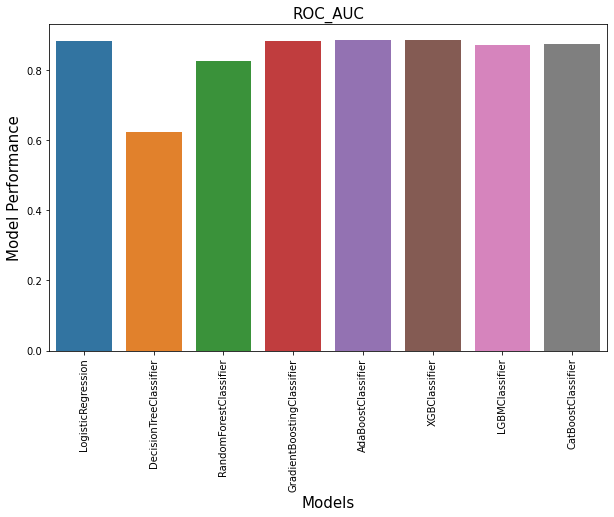

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('ROC_AUC', fontsize=15)
plt.show()

# 이러한 결과를 통해서 앙상블 모델 사용 시, XGB을 사용하도록 하자

# XGB

In [ ]:
# GridSearchCV + XGBClassifier

parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 500, 1000],
               'max_depth' : [2, 10, 15, 20],
               'max_leaves': [10, 15, 25, 50]}

xgb_model = xgb.XGBClassifier(seed=1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

grid_search = GridSearchCV(xgb_model, param_grid=parameters, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=2, max_leaves=50, n_estimators=1000, seed=42)
xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
y_pred = xgb_model.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

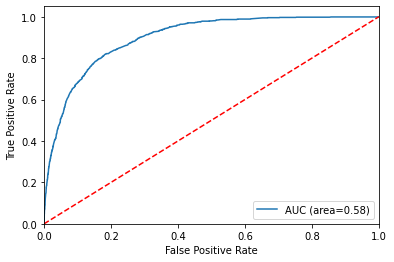

In [ ]:
# 시각화 
roc_auc=roc_auc_score(y,xgb_model.predict(X))
fpr,tpr,thresholds = roc_curve(y,xgb_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr,tpr,label="AUC (area=%0.2f)"%roc_auc)
plt.plot([0,1],[0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
preds = xgb_model.predict_proba(X_test)[:, 1]
preds

array([0.0110448 , 0.01442496, 0.00164278, ..., 0.00115372, 0.0073181 ,
       0.00114893], dtype=float32)

In [ ]:
preds = minmax.fit_transform(preds.reshape(-1, 1))

In [ ]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.946673525377229
0.9478014913859604


In [ ]:
# 풀 데이터 활용
xgb_model.fit(X,y)

XGBClassifier(max_depth=2, max_leaves=50, n_estimators=1000, seed=42)

In [ ]:
y_preds = xgb_model.predict_proba(X_sub)[:,1]
y_preds

array([0.05367555, 0.26755393, 0.00132279, ..., 0.00132279, 0.00220986,
       0.00103759], dtype=float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(y_preds.reshape(-1, 1))

In [ ]:
preds

array([[5.8188286e-02],
       [2.9364756e-01],
       [5.5300072e-04],
       ...,
       [5.5300072e-04],
       [1.5295758e-03],
       [2.3901486e-04]], dtype=float32)

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.058188
1,15305,0.293648
2,15306,0.000553
3,15307,0.042216
4,15308,0.011079


In [ ]:
# 제출 파일 생성 
submission.to_csv('submission_xgb.csv', index=False )

참고 문헌

- https://www.kaggle.com/code/alpertekiin/stroke-prediction-with-logistic-regression#Basic-Information-about-both-Data-and-Stroke

- https://www.kaggle.com/code/hikmatullahmohammadi/ps-s3-ep2-modeling-eda#4--Data-Preprocessing

- https://www.kaggle.com/code/jillanisofttech/tabular-classification-stroke-prediction-95-acc

- http://www.mohw.go.kr/react/al/sal0301vw.jsp?PAR_MENU_ID=04&MENU_ID=0403&CONT_SEQ=339009&page=1 <보건복지부 - 뇌졸중 연령>